<a href="https://colab.research.google.com/github/palinkapro/ML_ZoomCamp/blob/main/Homework_unit_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/data/AB_NYC_2019.csv')

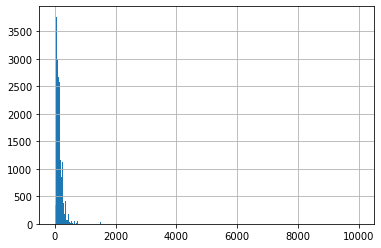

In [3]:
df.price.hist(bins=1000)

In [4]:
base = ['latitude', 
             'longitude', 
             'minimum_nights', 
             'number_of_reviews', 
             'reviews_per_month', 
             'calculated_host_listings_count', 
             'availability_365']

In [5]:
def prepare_X(df, na=0):
  df = df[base]
  df_num = df.fillna(na)
  X = df_num.values
  return X

In [6]:
def shuffle(df, seed=42):
  np.random.seed(seed)

  n = len(df)

  n_val = int(0.2 * n)
  n_test = int(0.2 * n)
  n_train = n - (n_val + n_test)

  idx = np.arange(n)
  np.random.shuffle(idx)

  df_shuffled = df.iloc[idx]

  df_train = df_shuffled.iloc[:n_train].copy()
  df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
  df_test = df_shuffled.iloc[n_train+n_val:].copy()

  y_train_orig = df_train.price.values
  y_val_orig = df_val.price.values
  y_test_orig = df_test.price.values

  y_train = np.log1p(df_train.price.values)
  y_val = np.log1p(df_val.price.values)
  y_test = np.log1p(df_test.price.values)

  del df_train['price']
  del df_val['price']
  del df_test['price']
  return df_train, df_val, df_test, y_train, y_val, y_test

In [7]:
def train_linear_regression(X, y, r=0.001):
  ones = np.ones(X.shape[0])
  X = np.column_stack([ones, X])
  XTX = X.T.dot(X)
  XTX = XTX + r * np.eye(XTX.shape[0])
  XTX_inv = np.linalg.inv(XTX)
  w_full = XTX_inv.dot(X.T).dot(y)

  return w_full[0], w_full[1:]


In [8]:
def rmse(y, y_pred):
  se = (y - y_pred) ** 2
  mse = se.mean()
  return np.sqrt(mse)

In [9]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [11]:
df_train, df_val, df_test, y_train, y_val, y_test = shuffle(df)

In [12]:
df.minimum_nights.median()

3.0

In [13]:
X_mean = round(df_train.reviews_per_month.mean(), 2)

In [14]:
X_train_null = prepare_X(df_train)
X_val_null = prepare_X(df_val)

In [15]:
w0, w = train_linear_regression(X_train_null, y_train, r=0)
y_pred = w0 + X_val_null.dot(w)
rmse(y_val, y_pred)

0.6430337788584176

In [16]:
X_train_mean = prepare_X(df_train, na=X_mean)
X_val_mean = prepare_X(df_val, na=X_mean)

In [17]:
w0, w = train_linear_regression(X_train_mean, y_train, r=0)
y_pred = w0 + X_val_mean.dot(w)
rmse(y_val, y_pred)

0.642754022673904

In [18]:
rs = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
root_err = []
for r in rs:
  w0, w = train_linear_regression(X_train_null, y_train, r=r)
  y_pred = w0 + X_val_null.dot(w)
  root_err.append(round(rmse(y_val, y_pred), 2))
rs[np.argmin(root_err)]
#root_err


0

In [19]:
rm_seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
root_err = []
for rm in rm_seeds:
  df_train, df_val, df_test, y_train, y_val, y_test = shuffle(df, seed=rm)
  X_train_null = prepare_X(df_train)
  X_val_null = prepare_X(df_val)
  w0, w = train_linear_regression(X_train_null, y_train, r=0)
  y_pred = w0 + X_val_null.dot(w)
  root_err.append(rmse(y_val, y_pred))
round(np.std(root_err), 3)

0.008

In [20]:
df_train, df_val, df_test, y_train, y_val, y_test = shuffle(df, seed=9)
df_full = pd.concat([df_train, df_val])
y_full = np.hstack([y_train, y_val])

In [21]:
X_train_null = prepare_X(df_full)
X_test_null = prepare_X(df_test)
w0, w = train_linear_regression(X_train_null, y_full, r=0.001)
y_pred = w0 + X_test_null.dot(w)
round(rmse(y_test, y_pred), 2)

0.65